In [1]:
import pandas as pd
import numpy as np
import os, sys
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import cm
from skimage import data, util, segmentation
import cv2
from skimage.segmentation import (morphological_chan_vese,
                                  morphological_geodesic_active_contour,
                                  inverse_gaussian_gradient,
                                  checkerboard_level_set)

In [7]:
def store_evolution_in(lst):
    """Returns a callback function to store the evolution of the level sets in
    the given list.
    """

    def _store(x):
        lst.append(np.copy(x))

    return _store

def one_channel(img, channel='gray'):
  '''
  Returns a single channel of the image.
  '''
  if channel=='gray':
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  elif channel=='blue':
    return img[:, :, 0]
  elif channel=='green':
    return img[:, :, 1]
  elif channel=='red':
    return img[:, :, 2]
  else:
    print('invalid channel name')

def blur(img, kernel=3, size=(512,512), form='bilateral'):
  '''
  Returns a resized, de-noised, blurred image 
  by either gaussian or bilateral blurring.
  '''
  if size!=None:
    img_resized = cv2.resize(img, dsize=size, interpolation=cv2.INTER_LINEAR)
  else:
    img_resized = img
  
  img_denoised = np.where(img_resized>30, img_resized, 0)

  if form=='bilateral':
    img_blur = cv2.bilateralFilter(img_denoised, kernel, 75, 9)
  elif form=='gaussian':
    img_blur = cv2.GaussianBlur(img_denoised, (kernel,kernel), 0) 
  elif form==None:
    img_blur = img_denoised
  else:
    print('invalid form of blurring')

  return img_blur

def equalise(img, technique='CLAHE'):
  '''
  Returns equalised image by either CLAHE or EqHist technique.
  '''
  if technique=='CLAHE':
    clahe = cv2.createCLAHE(clipLimit=5, tileGridSize=(10,10))
    equalised_img = clahe.apply(img)
  elif technique=='EqHist':
    equalised_img = cv2.equalizeHist(img)
  else:
    print('Choose technique as either `CLAHE` or `EqHist`')
    equalised_img = img
  
  return equalised_img

def edge_detection(img_path, centre_x, centre_y):
  """
  Performs edge detection on an image.

  This function reads an image from the specified path, applies a bilateral blur, 
  detects edges using the Canny algorithm, dilates the edges, applies a Gaussian blur 
  to the dilated edges, and creates a mask by flood filling from the specified centre 
  coordinates. The mask is then subtracted from the dilated edges.

  Parameters:
  img_path (str): Path to the image file.
  centre_x (int): x-coordinate of the centre point for flood filling.
  centre_y (int): y-coordinate of the centre point for flood filling.

  Returns:
  tuple: A tuple containing the blurred dilated edges and the mask.
  """
  img = cv2.imread(img_path)
  img_blur = blur(one_channel(img)[:], kernel=31, size=(1500, 1000), form='bilateral')
  edges = cv2.Canny(img_blur,10,40)

  kernel = np.ones((5,5),np.uint8)
  dilation = cv2.dilate(edges,kernel,iterations = 1)

  dilation_blur = blur(dilation, kernel=51, size=(1500, 1000), form='gaussian')

  mask = dilation.copy()
  cv2.floodFill(mask, None, (centre_x,centre_y), 255)
  mask = mask - dilation

  return dilation_blur, mask

def mgas(img, initialisation, iterations=200, smoothing=1, balloon=1.0, threshold=0.95):
  """
  Performs Morphological Geodesic Active Contour (MGAC) segmentation on an image.

  This function converts the input image to float, computes the inverse Gaussian gradient, 
  initializes the level set, and performs MGAC segmentation. The evolution of the segmentation 
  is stored for visualization.

  Parameters:
  img (ndarray): Input image.
  initialisation (list): List of initial pixel coordinates for the level set.
  iterations (int, optional): Number of iterations for the MGAC algorithm. Default is 200.
  smoothing (int, optional): Smoothing factor for the MGAC algorithm. Default is 1.
  balloon (float, optional): Balloon force for the MGAC algorithm. Default is 1.0.
  threshold (float, optional): Threshold for the MGAC algorithm. Default is 0.95.

  Returns:
  tuple: A tuple containing the final level set and the evolution of the segmentation.
  """
  image = util.img_as_float(img)
  gimage = inverse_gaussian_gradient(image)

  # Initial level set
  init_ls = np.zeros(image.shape, dtype=np.int8)
  for pixel in initialisation:
    init_ls[int(pixel[0]), int(pixel[1])] = 1
  
  # List with intermediate results for plotting the evolution
  evolution = []
  ls = []
  callback = store_evolution_in(evolution)
  ls = morphological_geodesic_active_contour(gimage, num_iter=iterations,
                                            init_level_set=init_ls,
                                            smoothing=smoothing, balloon=float(balloon),
                                            threshold=float(threshold),
                                            iter_callback=callback)
  
  return ls, evolution

<function matplotlib.pyplot.show(close=None, block=None)>

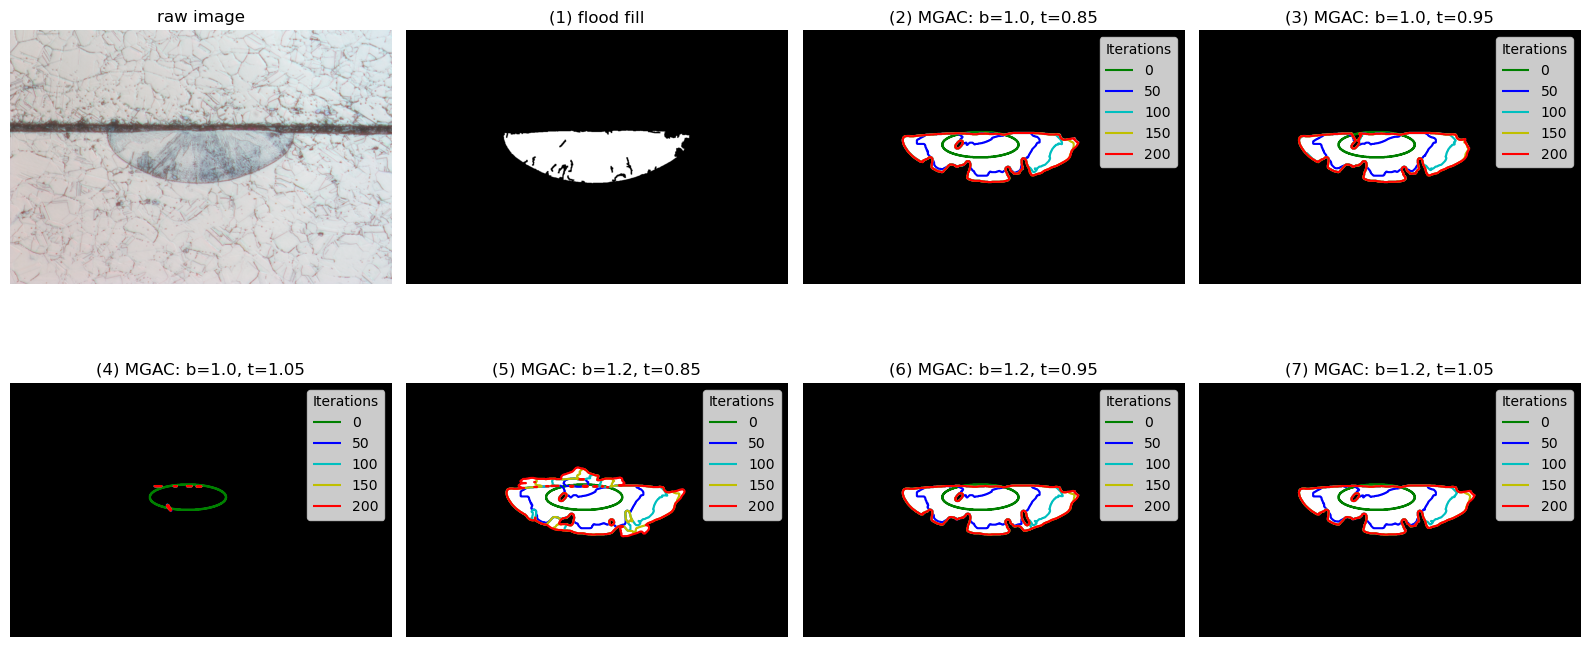

In [124]:
# define the starting ellipse
centre_x = 700 # x coordinate of the centre of the ellipse
centre_y = 450 # y coordinate of the centre of the ellipse
s = np.linspace(0, 2*np.pi, 3200) # 3200 is the number of points
r = centre_y + 50 * np.sin(s) # 50 is the size of the axis perpendicular to the rows
c = centre_x + 150 * np.cos(s) # 150 is the size of the axis perpendicular to the columns
init = np.array([r, c]).T

# Define the image path
img_path = 'data/example_image_2.png'

masks = []

fig, ax = plt.subplots(2, 4, figsize=(16, 8))
ax = ax.flatten()

ax[0].imshow(cv2.imread(img_path))
ax[0].set_title('raw image', fontsize=12)
ax[0].set_axis_off()

dilation_blur, mask = edge_detection(img_path, centre_x, centre_y)

masks.append(mask)
ax[1].imshow(mask, cmap='gray')
ax[1].set_title('(1) flood fill', fontsize=12)
ax[1].set_axis_off()

i = 2
for balloon in [1.0, 1.2]:
    for thresh in [0.85, 0.95, 1.05]:
        output, evolution = mgas(img=dilation_blur, initialisation=init, balloon=balloon, threshold=thresh)
        masks.append(output*255)
        ax[i].imshow(output, cmap="gray")
        ax[i].set_axis_off()
        iterations = [0, 50, 100, 150, 200]
        colors = ['g', 'b', 'c', 'y', 'r']
        le = []
        for index, iteration in enumerate([0, 50, 100, 150, 200]):
            contour = ax[i].contour(evolution[iteration], [0.5], colors=colors[index])
            le.append(contour.legend_elements()[0][0])

        ax[i].legend(le, iterations, title="Iterations", loc="upper right")
        title = f"({i}) MGAC: b={balloon}, t={thresh}"
        ax[i].set_title(title, fontsize=12)
        i += 1
plt.tight_layout()
plt.show


In [125]:
best_mask = 2

mask_path = os.path.splitext(img_path)[0]+'_mask.png'
cv2.imwrite(mask_path, masks[best_mask-1])

True